In [20]:
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from utils.dataprep import reindex_data, transform_indices
from utils.get_netflix_data import get_netflix_data
from models.pure_svd import build_svd_model, svd_scoring, svd_grid_search
from models.scaled_svd import build_ssvd_model, ssvd_scoring, ssvd_grid_search

In [2]:
topn = 20  # we calculate metric @ 20

ranks = [b * 2 ** n for n in range(3, 9) for b in [2, 3]]  # grid search rank parameters
scalings = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # grid search scaling parameters

### Benchmarking

#### Splitting function

In [3]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and movieid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

#### MovieLens benchmark

##### Prepare train, test and holdout

In [4]:
zip_path = "movielens.zip"

In [5]:
with zipfile.ZipFile(zip_path,"r") as z:
    z.extractall(".")

In [6]:
training_source = pd.read_csv('training')

In [7]:
train_val_, testset_val_, holdout_val_ = timepoint_split(
    training_source, time_split_q=0.95
)

In [8]:
train_val, data_index = transform_indices(train_val_, 'userid', 'movieid')
testset_val = reindex_data(testset_val_, data_index, fields="items")
holdout_val = reindex_data(holdout_val_, data_index, fields="items")

In [10]:
data_description = dict(
    users = data_index["users"].name,
    items = data_index["items"].name,
    feedback = 'rating',
    n_users = len(data_index["users"]),
    n_items = len(data_index["items"])
)

##### search for best hyperparams: PureSVD

In [11]:
svd_results = svd_grid_search(
    ranks, train_val, testset_val, holdout_val, data_description, topn=topn
)

In [12]:
# choose best based on ndcg

best_svd_idx = np.argmax([m['ndcg'] for m in svd_results.values()])
best_svd_rank = list(svd_results.keys())[best_svd_idx]
best_svd_rank

48

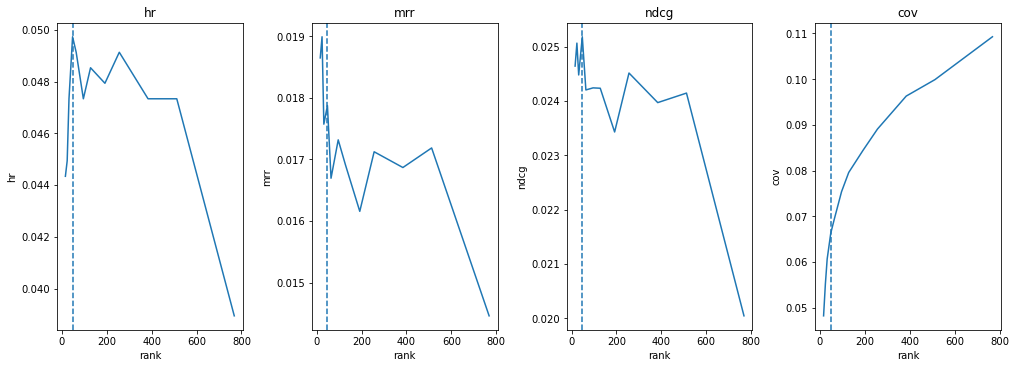

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5), constrained_layout=True)

metrics = ['hr', 'mrr', 'ndcg', 'cov']
for i, name in enumerate(metrics):
    vals = [m[name] for m in svd_results.values()]
    
    axes[i].plot(ranks, vals)
    axes[i].set_title(name)
    axes[i].set_xlabel("rank")
    axes[i].set_ylabel(name)
    axes[i].axvline(best_svd_rank, ls='--')

plt.show()

In [14]:
msg = f"PureSVD best rank: {best_svd_rank}\n\nMetrics:\n"
msg += f"hr: {[m['hr'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"mrr: {[m['mrr'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"ndcg: {[m['ndcg'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"cov: {[m['cov'] for m in svd_results.values()][best_svd_idx]}"
print(msg)

PureSVD best rank: 48

Metrics:
hr: 0.04973037747153984
mrr: 0.01787426174783874
ndcg: 0.025181831864702214
cov: 0.06632223957707557


##### search for best hyperparams: Scaled SVD

In [15]:
ssvd_results = ssvd_grid_search(
    ranks, scalings, train_val, testset_val, holdout_val, data_description, topn=topn
)

In [16]:
# choose best based on ndcg

best_ssvd_idx = np.argmax([m['ndcg'] for m in ssvd_results.values()])

(best_ssvd_rank, best_ssvd_scaling) = list(ssvd_results.keys())[best_ssvd_idx]
best_ssvd_rank, best_ssvd_scaling

(384, 0.4)

In [17]:
msg = f"Normalized SVD best rank: {best_ssvd_rank}; best scaling: {best_ssvd_scaling}\n\nMetrics:\n"
msg += f"hr: {[m['hr'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"mrr: {[m['mrr'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"ndcg: {[m['ndcg'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"cov: {[m['cov'] for m in ssvd_results.values()][best_ssvd_idx]}"
print(msg)

Normalized SVD best rank: 384; best scaling: 0.4

Metrics:
hr: 0.06051527860994608
mrr: 0.02271129941890877
ndcg: 0.03146918655076487
cov: 0.12910008410428933


#### Netflix benchmark

##### Prepare test sets

In [18]:
gz_path = "nf_prize_dataset.tar.gz"

In [21]:
training_source = get_netflix_data(gz_path, sample_frac=0.002)
training_source.reset_index(drop=True, inplace=True)
training_source.loc[:, 'rating'] = training_source.rating.astype(float)

In [22]:
train_val_, testset_val_, holdout_val_ = timepoint_split(
    training_source, time_split_q=0.95
)

In [23]:
train_val, data_index = transform_indices(train_val_, 'userid', 'movieid')
testset_val = reindex_data(testset_val_, data_index, fields="items")
holdout_val = reindex_data(holdout_val_, data_index, fields="items")

In [24]:
data_description = dict(
    users = data_index["users"].name,
    items = data_index["items"].name,
    feedback = 'rating',
    n_users = len(data_index["users"]),
    n_items = len(data_index["items"])
)

##### search for best hyperparams: PureSVD

In [25]:
svd_results = svd_grid_search(
    ranks, train_val, testset_val, holdout_val, data_description, topn=topn
)

In [26]:
# choose best based on ndcg

best_svd_idx = np.argmax([m['ndcg'] for m in svd_results.values()])
best_svd_rank = list(svd_results.keys())[best_svd_idx]
best_svd_rank

16

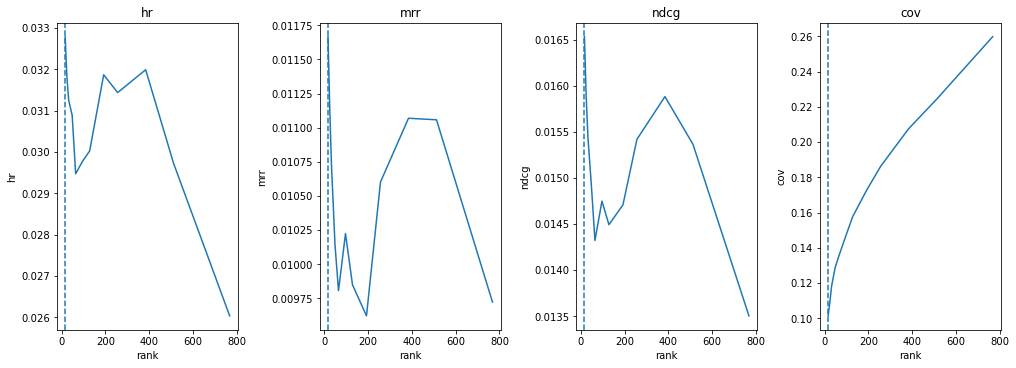

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5), constrained_layout=True)

metrics = ['hr', 'mrr', 'ndcg', 'cov']
for i, name in enumerate(metrics):
    vals = [m[name] for m in svd_results.values()]
    
    axes[i].plot(ranks, vals)
    axes[i].set_title(name)
    axes[i].set_xlabel("rank")
    axes[i].set_ylabel(name)
    axes[i].axvline(best_svd_rank, ls='--')

plt.show()

In [28]:
msg = f"PureSVD best rank: {best_svd_rank}\n\nMetrics:\n"
msg += f"hr: {[m['hr'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"mrr: {[m['mrr'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"ndcg: {[m['ndcg'] for m in svd_results.values()][best_svd_idx]}\n"
msg += f"cov: {[m['cov'] for m in svd_results.values()][best_svd_idx]}"
print(msg)

PureSVD best rank: 16

Metrics:
hr: 0.03278688524590164
mrr: 0.011665623864002939
ndcg: 0.016530026144987445
cov: 0.10128527521654093


##### search for best hyperparams: Normalized SVD

In [29]:
ssvd_results = ssvd_grid_search(
    ranks, scalings, train_val, testset_val, holdout_val, data_description, topn=topn
)

In [30]:
# choose best based on ndcg

best_ssvd_idx = np.argmax([m['ndcg'] for m in ssvd_results.values()])

(best_ssvd_rank, best_ssvd_scaling) = list(ssvd_results.keys())[best_ssvd_idx]
best_ssvd_rank, best_ssvd_scaling

(96, 0.1)

In [31]:
msg = f"Normalized SVD best rank: {best_ssvd_rank}; best scaling: {best_ssvd_scaling}\n\nMetrics:\n"
msg += f"hr: {[m['hr'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"mrr: {[m['mrr'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"ndcg: {[m['ndcg'] for m in ssvd_results.values()][best_ssvd_idx]}\n"
msg += f"cov: {[m['cov'] for m in ssvd_results.values()][best_ssvd_idx]}"
print(msg)

Normalized SVD best rank: 96; best scaling: 0.1

Metrics:
hr: 0.04168969116473261
mrr: 0.013975845961478673
ndcg: 0.020367015586990722
cov: 0.3727298127968706
